In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def make_grid(x_range,y_range):
    '''Function will take a list of x values and a list of y values, 
    and return a list of points in a grid defined by the two ranges'''
    import numpy as np
    xx,yy = np.meshgrid(x_range,y_range)
    points = np.vstack([xx.ravel(), yy.ravel()]).T
    return points

In [4]:
def do_Kfold(model,X,y,k,scaler = None, random_state = 146):
    from sklearn.model_selection import KFold
    
    kf = KFold(n_splits=k, random_state = random_state, shuffle=True)

    train_scores = []
    test_scores = []

    for idxTrain, idxTest in kf.split(X):
        Xtrain = X[idxTrain, :]
        Xtest = X[idxTest, :]
        ytrain = y[idxTrain]
        ytest = y[idxTest]
        if scaler != None:
            Xtrain = scaler.fit_transform(Xtrain)
            Xtest = scaler.transform(Xtest)

        model.fit(Xtrain,ytrain)

        train_scores.append(model.score(Xtrain,ytrain))
        test_scores.append(model.score(Xtest,ytest))
        
    return train_scores, test_scores

In [5]:
def compare_classes(actual, predicted, names=None):
    '''Function returns a confusion matrix, and overall accuracy given:
            Input:  actual - a list of actual classifications
                    predicted - a list of predicted classifications
                    names (optional) - a list of class names
    '''
    accuracy = sum(actual==predicted)/actual.shape[0]
    
    classes = pd.DataFrame(columns = ['Actual', 'Predicted'])
    classes['Actual'] = actual
    classes['Predicted'] = predicted

    conf_mat = pd.crosstab(classes['Actual'], classes['Predicted'])
    
    if type(names) != type(None):
        conf_mat.index = names
        conf_mat.index.name = 'Actual'
        conf_mat.columns = names
        conf_mat.columns.name = 'Predicted'
    
    print('Accuracy = ' + format(accuracy, '.2f'))
    return conf_mat, accuracy

In [6]:
def plot_groups(points, groups, colors, 
               ec='black', ax='None',s=30, alpha=0.5,
               figsize=(6,6)):
    '''Creates a scatter plot, given:
            Input:  points (array)
                    groups (an integer label for each point)
                    colors (one rgb tuple for each group)
                    ec (edgecolor for markers, default is black)
                    ax (optional handle to an existing axes object to add the new plot on top of)
            Output: handles to the figure (fig) and axes (ax) objects
    '''
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create a new plot, unless something was passed for 'ax'
    if ax == 'None':
        fig,ax = plt.subplots(figsize=figsize)
    else:
        fig = plt.gcf()
    
    for i,lbl in enumerate(np.unique(groups)):
        idx = (groups==lbl)
        ax.scatter(points[idx,0], points[idx,1],color=colors[i],
                    ec=ec,alpha=alpha,label = lbl,s=s)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    return fig, ax

## Part 1: 2 features only (wine data)

In [7]:
data = pd.read_csv('../../data/wine_data.csv')
data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,Cultivar_1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,Cultivar_1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,Cultivar_1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,Cultivar_1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,Cultivar_1


In [8]:
X_df = data.drop(columns = 'target')
X_df.shape

(178, 13)

In [9]:
cols = ['proline', 'flavanoids']
X1 = np.array(X_df[cols])

In [10]:
y = data['target'].values
y_names = np.unique(data['target'].values)

Let's start with a single training/testing split and inspect the results, while varying some of the hyperparamters of the decision tree:

In [11]:
from sklearn.model_selection import train_test_split as tts
Xtrain,Xtest,ytrain,ytest = tts(X1, y, test_size=0.3, random_state=201)

In [12]:
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn import tree #only for plotting, you will not need for HW etc.

In [13]:
#Create and fit classifier
#Print test and train scores

dtc = DTC(random_state=201)
dtc.fit(Xtrain, ytrain)

print(dtc.score(Xtrain, ytrain))
print(dtc.score(Xtest, ytest))

1.0
0.8518518518518519


In [14]:
#Make predictions and get confusion matrix for test

ypred = dtc.predict(Xtest)
cfmatrix, acc = compare_classes(ytest, ypred, names = y_names)

print("Accuracy = " + str(acc) + "\n\n")
print(cfmatrix)

Accuracy = 0.85
Accuracy = 0.8518518518518519


Predicted   Cultivar_1  Cultivar_2  Cultivar_3
Actual                                        
Cultivar_1          16           2           0
Cultivar_2           1          24           1
Cultivar_3           0           4           6


In [15]:
#You don't have to make a plot to get the depth
dtc.get_depth()

7

We can also look at the tree itself. Let's check it out for different hyperparameter values.

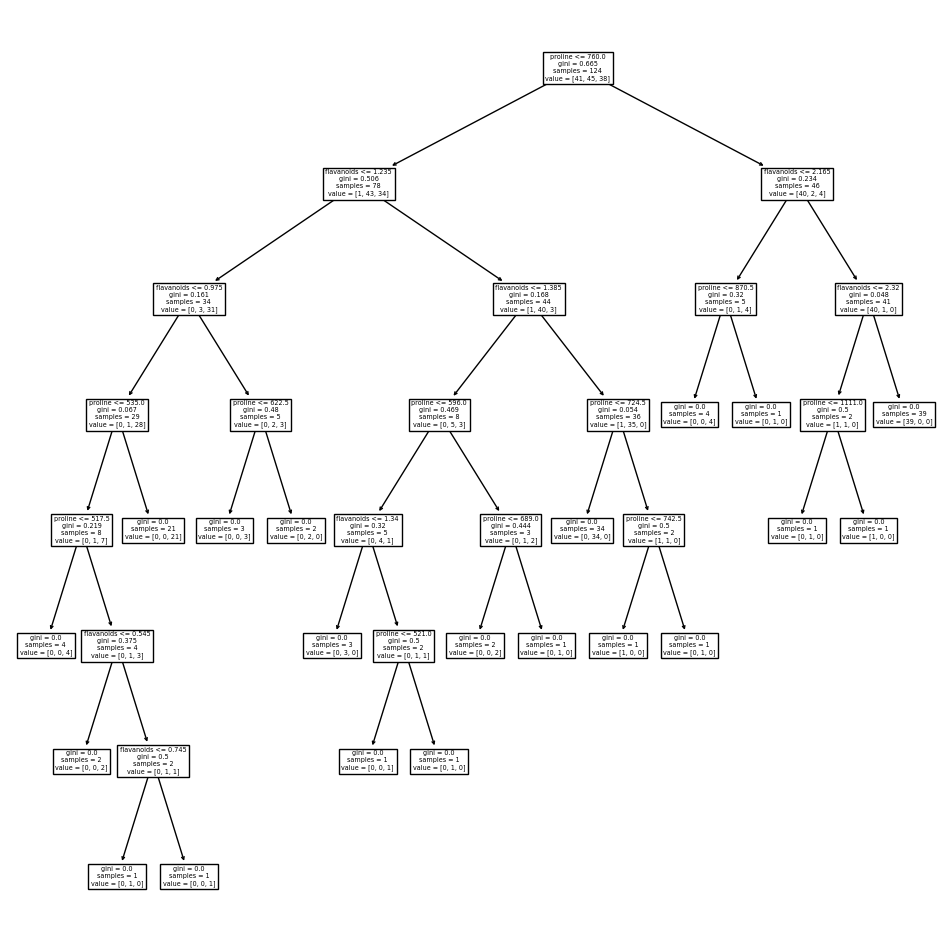

In [16]:
#These plots are not needed for the assignments, they are just for learning
plt.figure(figsize=(12,12))
tree.plot_tree(dtc,feature_names = cols)
plt.savefig('DecisionTree_Example.svg', bbox_inches='tight')
plt.show()

Let's look at the classification regions (and perhaps see how they change when we change the max depth)

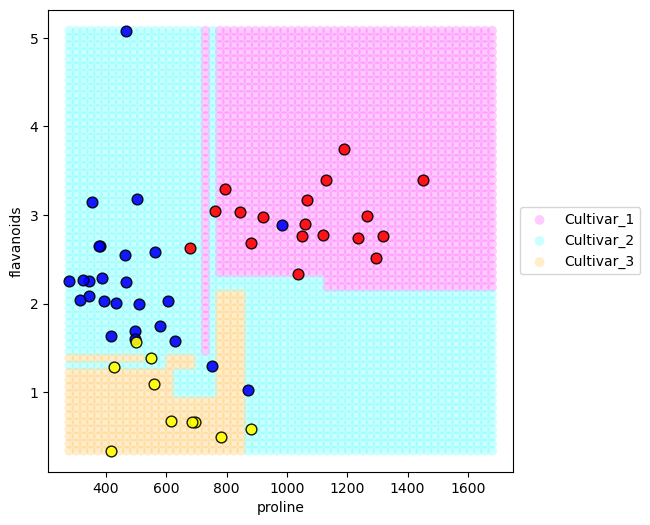

In [17]:
#These plots are not needed for the assignments, they are just for learning
# Plot the classification regions along with the test data
x_range = np.linspace(X1[:,0].min(), X1[:,0].max(), 60)
y_range = np.linspace(X1[:,1].min(), X1[:,1].max(), 60)

points = make_grid(x_range,y_range)

y_regions = dtc.predict(points)

# Need some colors for our plot
front_colors = ['red', 'blue', 'yellow']
back_colors = ['magenta', 'cyan', 'orange']

fig,ax = plot_groups(points,y_regions, back_colors,ec='None',s=50, alpha = 0.2)
plot_groups(Xtest,ytest,front_colors,ax=ax, s = 60, alpha = 0.9) #plot test data
#plot_groups(Xtrain,ytrain,back_colors,ax=ax, s = 60, alpha = 0.9) #plot train data
plt.xlabel(cols[0])
plt.ylabel(cols[1])
plt.legend(y_names, bbox_to_anchor=[1,0.5], loc='center left')
plt.show()

## Part 2: Using all features and optimizing a hyperparameter

In [19]:
depth_range = np.arange(2,10)
k = 10

train = []
test = []

for d in depth_range:
    dtc = DTC(max_depth = d, random_state=201)
    tr, te = do_Kfold(dtc, Xtrain, ytrain, k, random_state=201)
    train.append(np.mean(tr))
    test.append(np.mean(te))

In [21]:
def output_optimal_hyperparameter(train, test, params):
    max_idx = np.argmax(test)
    print("optimal hyperparameter =", params[max_idx])
    print("training score at optimal hyperaparameter:", train[max_idx])
    print("testing score at optimal hyperaparameter:", test[max_idx])
    return params[max_idx]

In [23]:
import functools

get_optimal_max_depth = functools.partial(output_optimal_hyperparameter, train, test, depth_range)
get_optimal_max_depth()

optimal hyperparameter: 5
training score at optimal hyperaparameter: 0.9820543758043758
testing score at optimal hyperaparameter: 0.8685897435897436


In [ ]:
plt.plot(depth_range, train, '-xk', label='Training')
plt.plot(depth_range, test, '-xr', label='Testing')
plt.xlabel('Max Depth')
plt.ylabel('Classification Accuracy')
plt.legend()
plt.show()

In practice, you could probably improve performance overall by modifying multiple hyperparameters (we will talk about an easier way to do that later).

In [ ]:
print(test)

In [ ]:
tr,te = do_Kfold(DTC(random_state = 201, max_depth = #what did we pick),X,y,10)

In [ ]:
plt.figure(figsize = (6,6))
sns.stripplot(data = pd.DataFrame(zip(tr,te), columns = ['Training', 'Testing']), size=10, palette = 'winter',
             alpha = 0.5, jitter = True)
plt.show()

In [ ]:
print(np.mean(tr), np.mean(te))

## Part 3: Random Forests

Let's take a look with just two predictors so that we can compare the results from using a Random Forest versus a single decision tree.

In [24]:
from sklearn.ensemble import RandomForestClassifier as RFC

cols = ['proline', 'flavanoids']
X1 = X_df[cols]

#same tts as above
Xtrain,Xtest,ytrain,ytest = tts(X1.values,y,test_size=0.3, random_state = 201)

In [25]:
#Create classifier, fit it, and make predictions for the test data

rfc = RFC(random_state=201)
rfc.fit(Xtrain, ytrain)

RandomForestClassifier(random_state=201)

In [ ]:
# Plot the classification regions along with the test data
x_range = np.linspace(X1.values[:,0].min(), X1.values[:,0].max(), 60)
y_range = np.linspace(X1.values[:,1].min(), X1.values[:,1].max(), 60)

points = make_grid(x_range,y_range)

y_regions = rfc.predict(points)

# Need some colors for our plot
front_colors = ['red', 'blue', 'yellow']
back_colors = ['magenta', 'cyan', 'orange']

fig,ax = plot_groups(points,y_regions, back_colors, ec='None',s=50, alpha = 0.2)
plot_groups(Xtest,ytest,front_colors,ax=ax, s = 60, alpha = 0.9)

plt.xlabel(cols[0])
plt.ylabel(cols[1])
plt.legend(y_names, bbox_to_anchor=[1,0.5], loc='center left')
plt.show()

In [ ]:
compare_classes(ytest, y_pred, y_names)

What's different about the classification regions?

The same optimal hyperparameters for a decision tree may not be optimal for the Random Forest. Let's use all of the data and try to optimize max_depth for 100 trees.


In [ ]:
depth_range = np.arange(2,10)
k = 10

train = []
test = []

for d in depth_range:
    pass

In [ ]:
plt.plot(depth_range, train, '-xk', label='Training')
plt.plot(depth_range, test, '-xr', label='Testing')
plt.xlabel('Max Depth')
plt.ylabel('Classification Accuracy')
plt.legend()
plt.show()

Let's compare on 1 tts with all predictors:

In [ ]:
Xtrain,Xtest,ytrain,ytest = tts(X,y,test_size=0.4, random_state = 146) #yes, this is 146 on purpose

In [ ]:
dtc = DTC(random_state = 201, max_depth = 3)
dtc.fit(Xtrain, ytrain)
print(dtc.score(Xtrain,ytrain), 'train')
compare_classes(ytest, dtc.predict(Xtest), y_names)

In [ ]:
rfc = RFC(random_state = 201, n_estimators = 200, max_depth = 4)
rfc.fit(Xtrain, ytrain)
print(rfc.score(Xtrain, ytrain), 'train')
compare_classes(ytest, rfc.predict(Xtest), y_names)

## Part 4: Using the GridSearch

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV

param_grid = dict(n_estimators=[1,100,500],max_depth = [2,3,4,5],
                 min_samples_split = [2,3,4,5]) #params to test
cv = KFold(n_splits=10, random_state=146, shuffle = True)
grid = GridSearchCV(RFC(random_state = 146), param_grid=param_grid, cv=cv, 
                    scoring='accuracy')

In [ ]:
#Fit the grid search

In [ ]:
print(
    f'The best parameters are {grid.best_params_} with a score of {grid.best_score_:.2f}'
)

In [ ]:
results = pd.DataFrame(grid.cv_results_)[['param_n_estimators','param_max_depth',
                                'param_min_samples_split','mean_test_score','rank_test_score']]

In [ ]:
results.head()

In [ ]:
results[results['rank_test_score'] == 1]

In [ ]:
#which should we use?